# Cumulative sums
The research question for this notebook is: "What parameters can we best use to say something about directionality?"

We sort the bins based on how full they are. The y-axis will be the cumulative sum of this data fraction. The x-axis will be the percentage of the free volume in which this data is. 

The hypothesis is that this will be a straight line for non-directional interaction between pairs and would be steeper for more directional interactions.

In [1]:
import sys

sys.path.append('..//helpers//')
sys.path.append('..//classes//')
sys.path.append('..//constants//')

from density_helpers import find_available_volume, prepare_df
from geometry_helpers import (get_vdw_distance_contact,
                                      make_coordinate_df)
from Settings import Settings

from paths import WORKDIR, RESULTSDIR, RADII_CSV

central_groups = ["RCOMe", "RNO2", "ArCI", "NO3", "RC6F5", "H2O", "RC6H5"]
contact_groups = ["ArCH", "C2CH2", "CCH3", "CF", "R2CO", "RC6H5", "RCN", "XH", "XH"]
to_count =       ["H",    "H",      "H",   "F", "O",     "centroid", "N", "H", "O"]

In [2]:
%matplotlib notebook
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from matplotlib.widgets import Slider

import numpy as np

In [3]:
# make volume csv if not exists
import os
import csv

tolerance = 0.5

if not os.path.exists('../results/free_volumes.csv'):
    with open('../results/free_volumes.csv', 'w', newline='') as freevolumesfile:
        csvwriter = csv.writer(freevolumesfile)
        csvwriter.writerow(['central', 'contact', 'to_count', 'volume'])

        for central_group in central_groups:   
            for to_count_contact, contact_group in zip(to_count, contact_groups):
                datafile = ".\\data\\" + central_group + "\\" + central_group + "_" + contact_group + "_vdw.5.cor"

                settings = Settings(RESULTSDIR, RADII_CSV, datafile)
                settings.set_atom_to_count(to_count_contact)

                ############ find out volume of the central group 
                aligned_df = pd.read_csv(settings.get_kabsch_aligned_csv_filename(), header=0)
                avg_fragment = pd.read_csv(settings.get_avg_frag_filename())

                contact_group_radius = get_vdw_distance_contact(aligned_df, settings)
                volume = find_available_volume(avg_fragment=avg_fragment, extra=(tolerance + contact_group_radius))
                
                csvwriter.writerow([central_group, contact_group, to_count_contact, volume])
                
                print(f"Volume {central_group}, {contact_group} ({to_count_contact}) is {volume}")

In [4]:
volumes = pd.read_csv('../results/free_volumes.csv')

volumes["directionality"] = np.nan

display(volumes)

central contact to_count    volume  directionality
0    RCOMe      CF        F  293.8445             NaN
1    RCOMe     RCN        N  314.0205             NaN
2    RCOMe    R2CO        O  307.2400             NaN
3    RCOMe      XH        H  210.7475             NaN
4    RCOMe      XH        O  307.6365             NaN
..     ...     ...      ...       ...             ...
56   RC6H5    R2CO        O  384.6525             NaN
57   RC6H5      XH        H  266.4490             NaN
58   RC6H5      XH        O  384.3250             NaN
59   RC6H5    CCH3        H  266.4425             NaN
60   RC6H5   C2CH2        H  266.2945             NaN

[61 rows x 5 columns]

In [7]:
def make_plot(central_group, contact_group, to_count_contact, resolution, volumes):
    datafile = ".\\data\\" + central_group + "\\" + central_group + "_" + contact_group + "_vdw.5.cor"

    settings = Settings(RESULTSDIR, RADII_CSV, datafile)
    settings.set_atom_to_count(to_count_contact)
    settings.set_resolution(resolution)

    density_df = pd.read_hdf(settings.get_density_df_filename(), settings.get_density_df_key())

    density_df['datafrac_normalized'] = density_df[to_count_contact] / density_df[to_count_contact].sum()
    density_df = density_df.sort_values(by=to_count_contact, ascending=False).reset_index()
    density_df['cum_data'] = density_df["datafrac_normalized"].cumsum()
    density_df['cum_vol'] = density_df.index * resolution**3

    free_volume = volumes.loc[(volumes.central == central_group) & (volumes.contact == contact_group) & (volumes.to_count == to_count_contact), 'volume'].item()  
    
    density_df = density_df[density_df['cum_vol'] <= free_volume]
    density_df['cum_vol'] = density_df['cum_vol'] / free_volume
        
    cluster_frac = 0.25
    threshold = density_df.datafrac_normalized.max() * cluster_frac
    in_cluster = density_df[density_df.datafrac_normalized >= threshold]
            
    ax = plt.gca()
    color = next(ax._get_lines.prop_cycler)['color']
    
    plt.plot(density_df['cum_vol'], density_df['cum_data'], color=color, label=f"{central_group}--{contact_group} ({to_count_contact})")
    plt.scatter(in_cluster['cum_vol'], in_cluster['cum_data'], color=color)

<IPython.core.display.Javascript object>


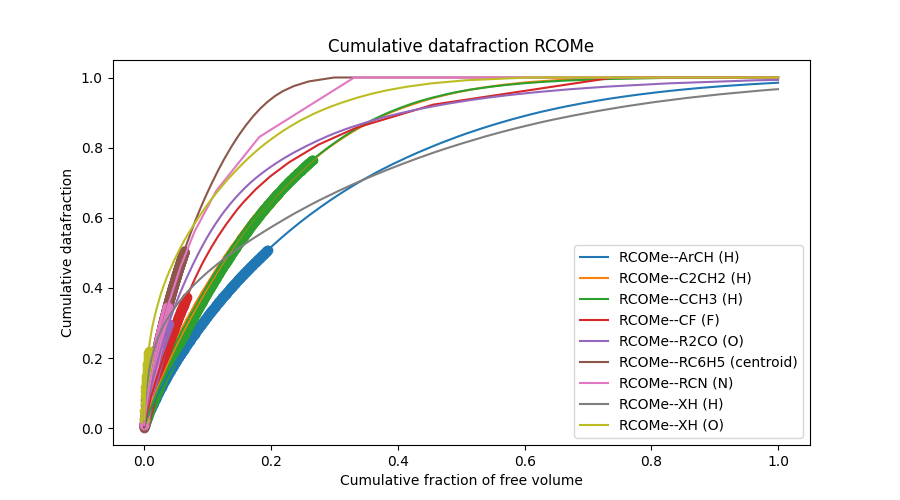

<IPython.core.display.Javascript object>


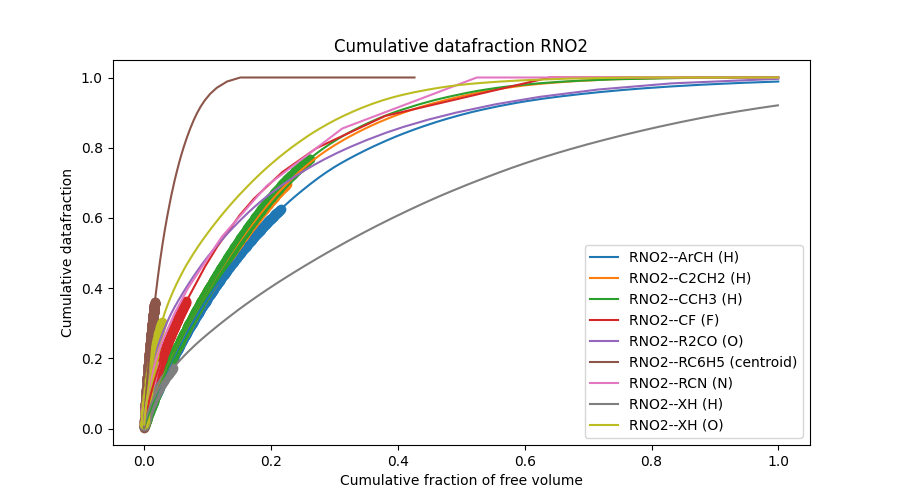

<IPython.core.display.Javascript object>


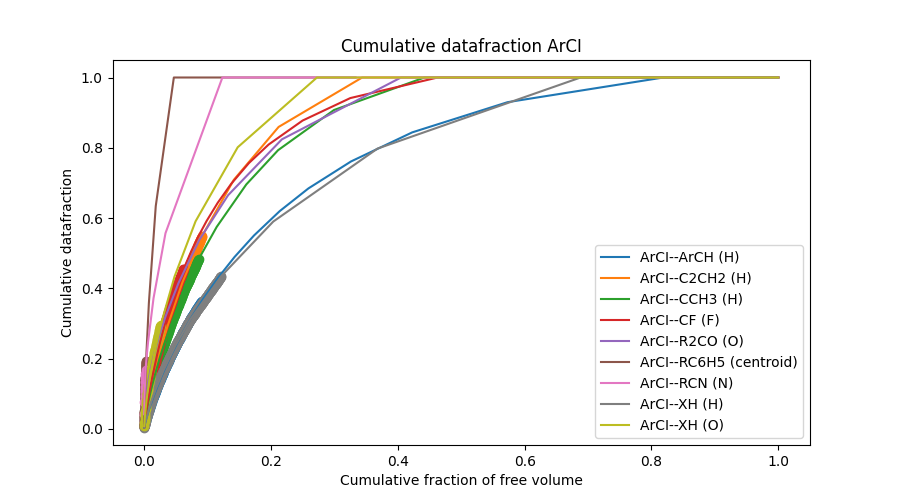

<IPython.core.display.Javascript object>


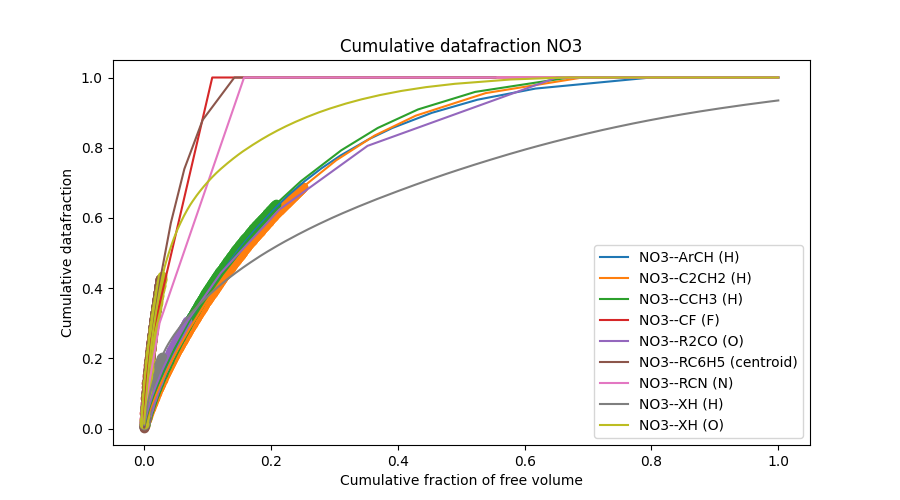

<IPython.core.display.Javascript object>


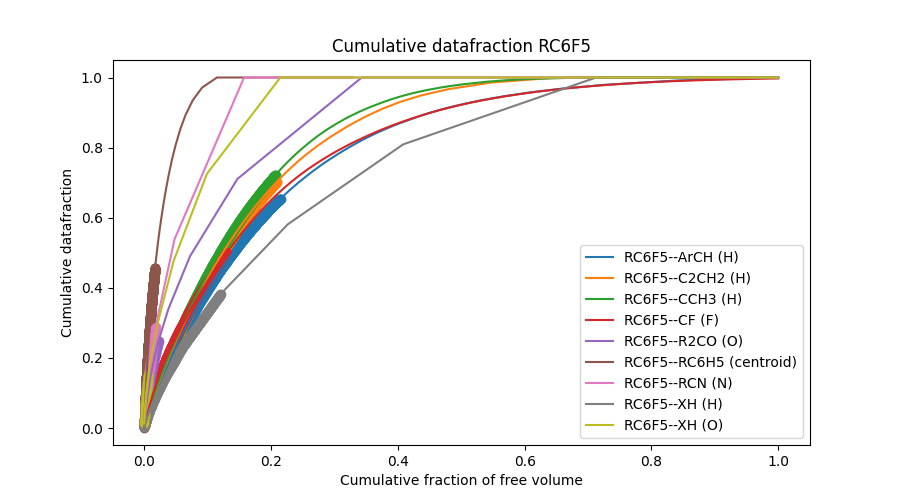

<IPython.core.display.Javascript object>


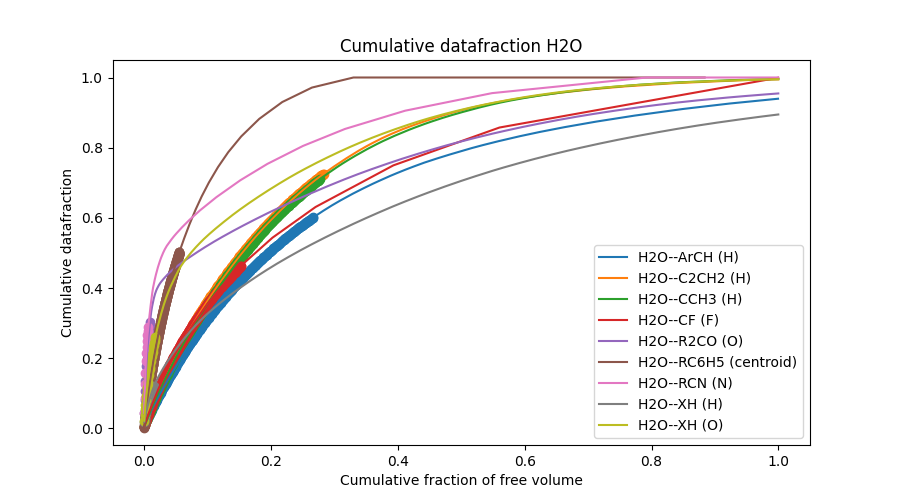

<IPython.core.display.Javascript object>


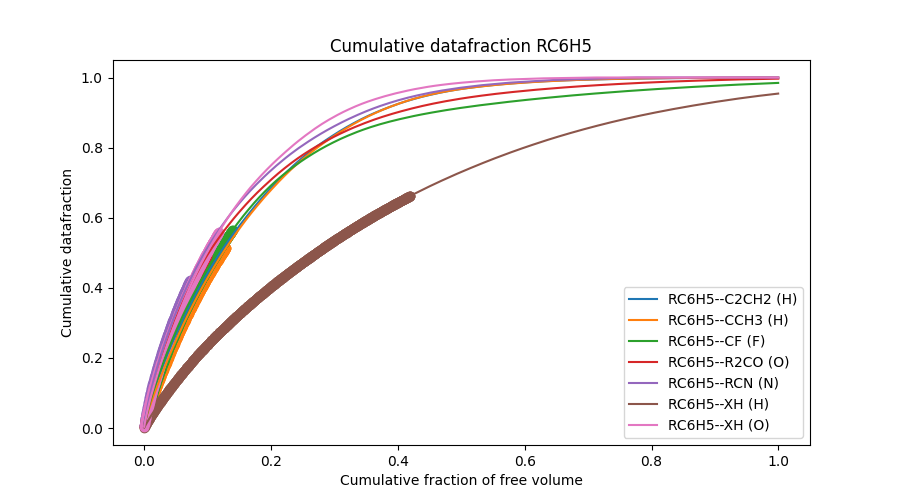

In [8]:
resolution = 0.50

for central_group in central_groups:
    plt.figure(figsize=(9, 5))
    plt.title("Cumulative datafraction " + central_group)
    
    for to_count_contact, contact_group in zip(to_count, contact_groups):
        
        if central_group == "RC6H5" and contact_group == "RC6H5" or central_group == "RC6H5" and contact_group == "ArCH":
            continue
            
        make_plot(central_group, contact_group, to_count_contact, resolution, volumes)
        
    plt.ylabel("Cumulative datafraction")
    plt.xlabel("Cumulative fraction of free volume")
    plt.legend(loc="lower right")
    plt.savefig(f'../results/cumsums/cumsum_data_and_volume_{central_group}_res{resolution}.png')
    plt.show()

<IPython.core.display.Javascript object>


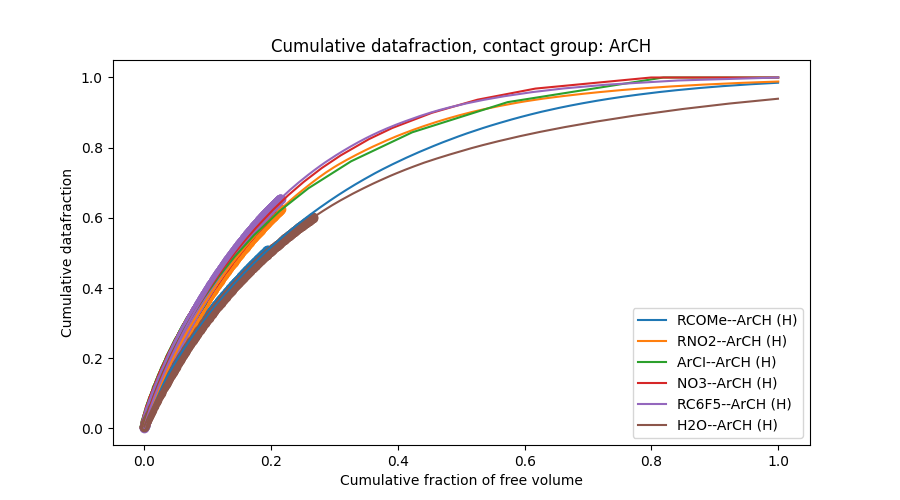

<IPython.core.display.Javascript object>


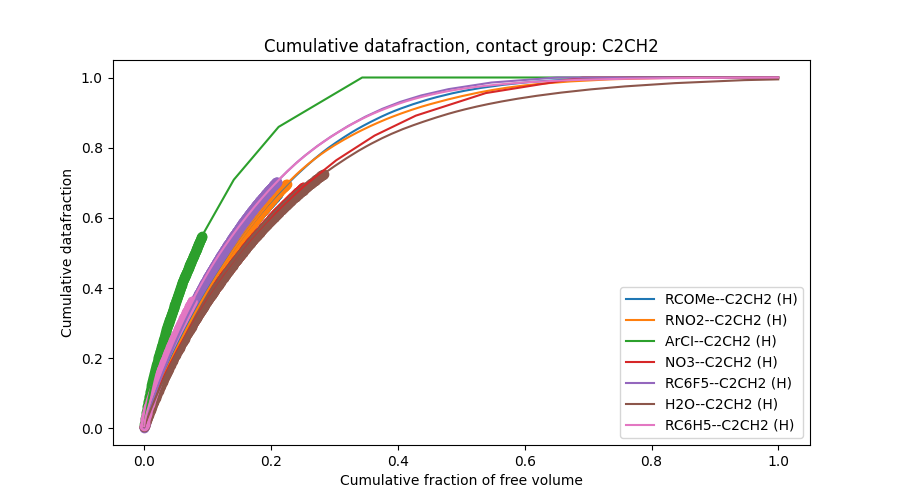

<IPython.core.display.Javascript object>


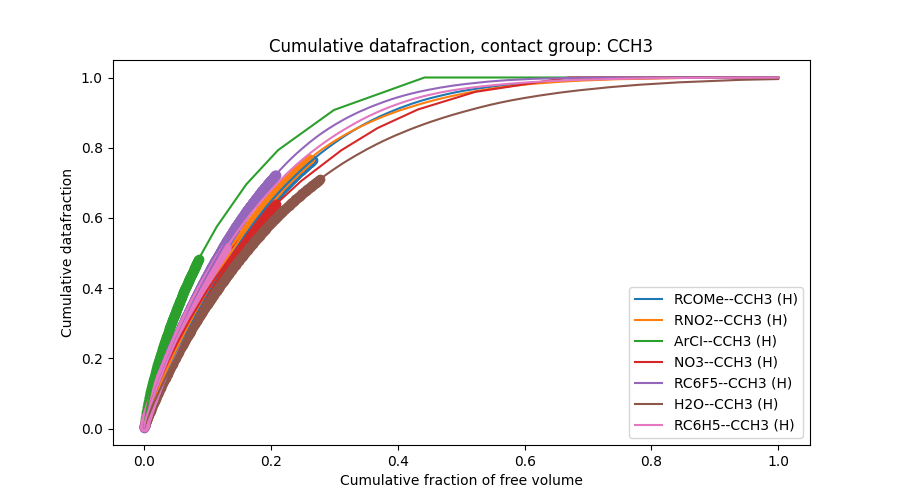

<IPython.core.display.Javascript object>


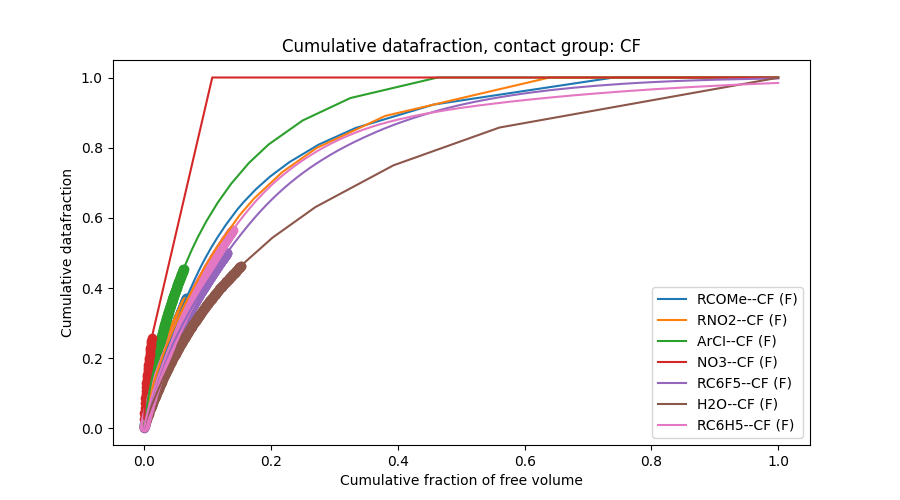

<IPython.core.display.Javascript object>


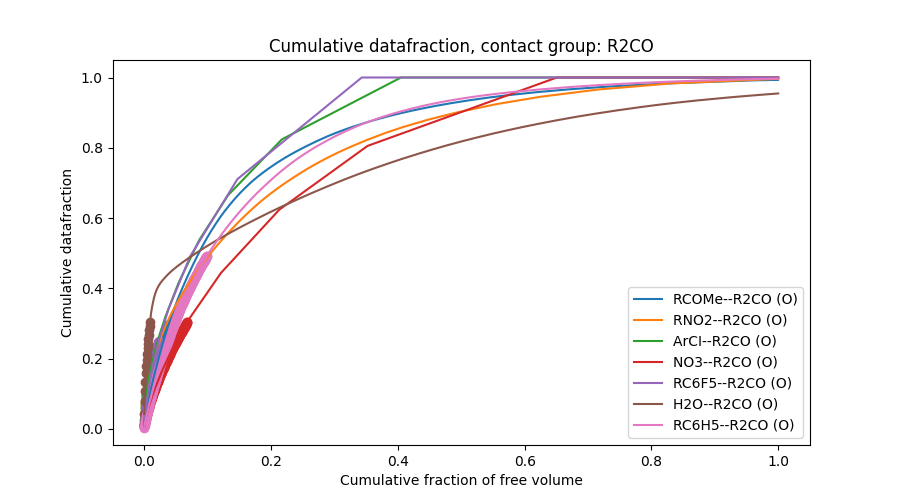

<IPython.core.display.Javascript object>


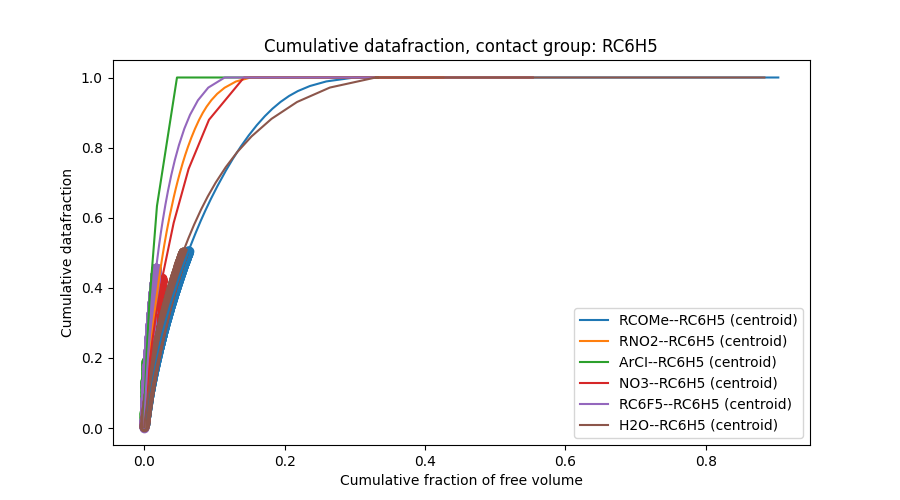

<IPython.core.display.Javascript object>


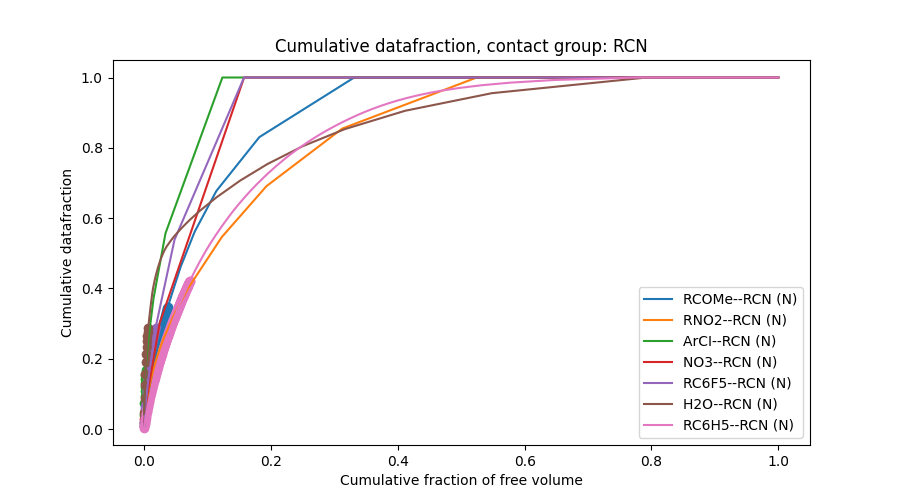

<IPython.core.display.Javascript object>


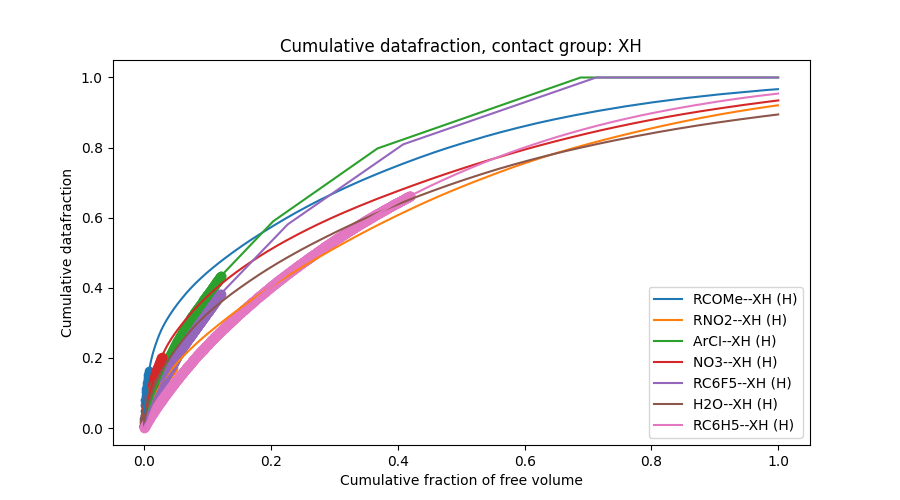

<IPython.core.display.Javascript object>


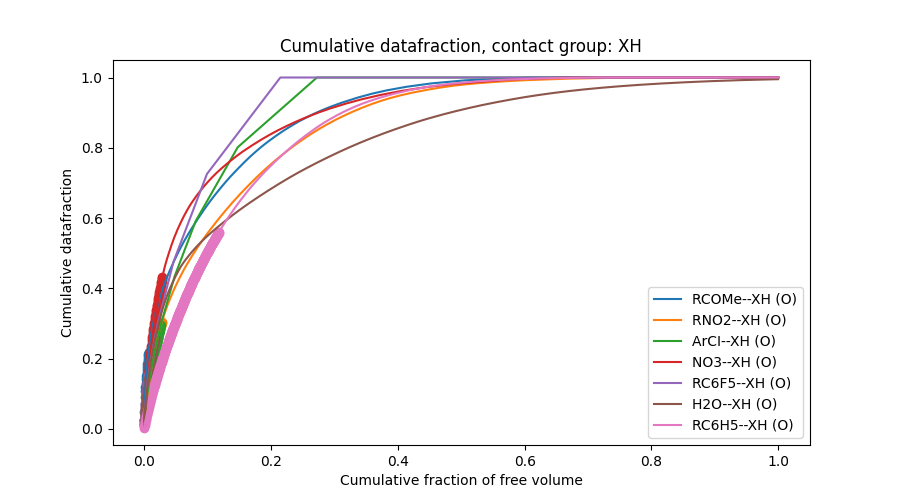

In [15]:
resolution = 0.50
tolerance = 0.50

for to_count_contact, contact_group in zip(to_count, contact_groups):
    plt.figure(figsize=(9, 5))
    plt.title("Cumulative datafraction, contact group: " + contact_group)

    for central_group in central_groups:
            
        if central_group == "RC6H5" and contact_group == "RC6H5" or central_group == "RC6H5" and contact_group == "ArCH":
            continue
            
        make_plot(central_group, contact_group, to_count_contact, resolution, volumes)

    plt.ylabel("Cumulative datafraction")
    plt.xlabel("Cumulative fraction of free volume")
    plt.legend(loc="lower right")
    plt.savefig(f'../results/cumsums/cumsum_data_and_volume_per_contact_{contact_group}_res{resolution}.png')

# Analyzing the plots
We see that some of the lines do not get to to the datafraction of 1.0. What is going on there?

Is there a way to show how we got the directionality in these plots?


In [13]:
def calc_all_directionalities(cluster_frac, resolution):
    directionalities = []
    
    for to_count_contact, contact_group in zip(to_count, contact_groups):
        for central_group in central_groups:
            if central_group == "RC6H5" and contact_group == "RC6H5" or central_group == "RC6H5" and contact_group == "ArCH":
                continue
    
            datafile = ".\\data\\" + central_group + "\\" + central_group + "_" + contact_group + "_vdw.5.cor"

            settings = Settings(RESULTSDIR, RADII_CSV, datafile)
            settings.set_atom_to_count(to_count_contact)
            settings.set_resolution(resolution)

            density_df = pd.read_hdf(settings.get_density_df_filename(), settings.get_density_df_key())

            density_df['datafrac_normalized'] = density_df[to_count_contact] / density_df[to_count_contact].sum()
            
            threshold = density_df.datafrac_normalized.max() * cluster_frac
            in_cluster = density_df[density_df.datafrac_normalized >= threshold]
            
            Vavailable = volumes.loc[(volumes.central == central_group) & (volumes.contact == contact_group) & (volumes.to_count == to_count_contact), 'volume'].item()  

            datafrac = in_cluster.datafrac_normalized.sum()
            Vcluster = len(in_cluster) * resolution**3
            
            directionality = datafrac / Vcluster * Vavailable
            directionalities.append(directionality)
            
    return directionalities


In [16]:
directionalities = calc_all_directionalities(0.25, 0.5)

<IPython.core.display.Javascript object>


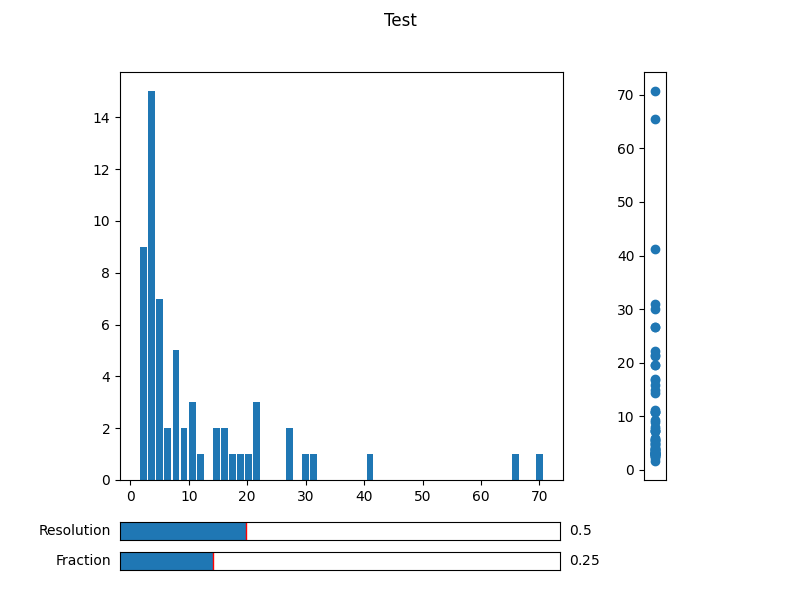

In [17]:
frac = 0.25
res = 0.5

fig = plt.figure(figsize=(8,6))
fig.suptitle('Test')
gs = fig.add_gridspec(1, 4)
plt.subplots_adjust(left=0.15, bottom=0.2)

ax1 = fig.add_subplot(gs[0, 0:3])
ax1.hist(directionalities, bins=50, rwidth=0.85)

ax2 = fig.add_subplot(gs[0, 3])
x = [0] * len(directionalities)

scatter2 = ax2.scatter(x, directionalities)
ax2.set_xlim(-10, 10)
ax2.axes.get_xaxis().set_visible(False)  # remove the x-axis and its ticks
ax2.set_aspect(5, adjustable='box')  # adjustable='box' is important here


axres = plt.axes([0.15, 0.1, 0.55, 0.03])
sres = Slider(axres, 'Resolution', 0.1, 1.5, valinit=res, valstep=0.1)

axfrac = plt.axes([0.15, 0.05, 0.55, 0.03])
sfrac = Slider(axfrac, 'Fraction', 0.05, 1, valinit=frac, valstep=0.05)


def update(val):
    print("Hoi")
    res = sres.val
    frac = sfrac.val
    
    ax1.clear()
    ax2.clear()
    
    directionalities = calc_all_directionalities(frac, res)
    
    # redraw axis 1
    ax1 = fig.add_subplot(gs[0, 0:3])
    ax1.hist(directionalities, bins=50, rwidth=0.85)
    
    
#     ax1.hist(directionalities, bins=50, rwith=0.85)

#     scatter2.set_offsets(x, directionalities)   
    
sfrac.on_changed(update)
sres.on_changed(update)



plt.show()

<IPython.core.display.Javascript object>


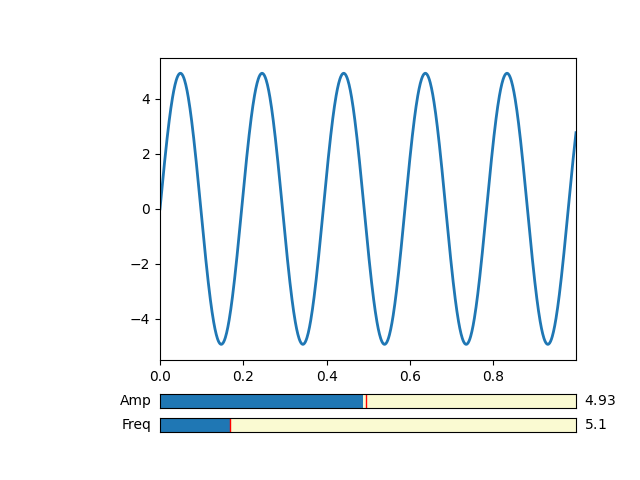

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
t = np.arange(0.0, 1.0, 0.001)
a0 = 5
f0 = 3
delta_f = 5.0
s = a0 * np.sin(2 * np.pi * f0 * t)

l, = plt.plot(t, s, lw=2)

ax.margins(x=0)

axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axamp = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=f0, valstep=delta_f)
samp = Slider(axamp, 'Amp', 0.1, 10.0, valinit=a0)


def update(val):
    print("hoi", val)
    amp = samp.val
    freq = sfreq.val
    l.set_ydata(amp*np.sin(2*np.pi*freq*t))
    fig.canvas.draw_idle()


sfreq.on_changed(update)
samp.on_changed(update)

plt.show()

<IPython.core.display.Javascript object>


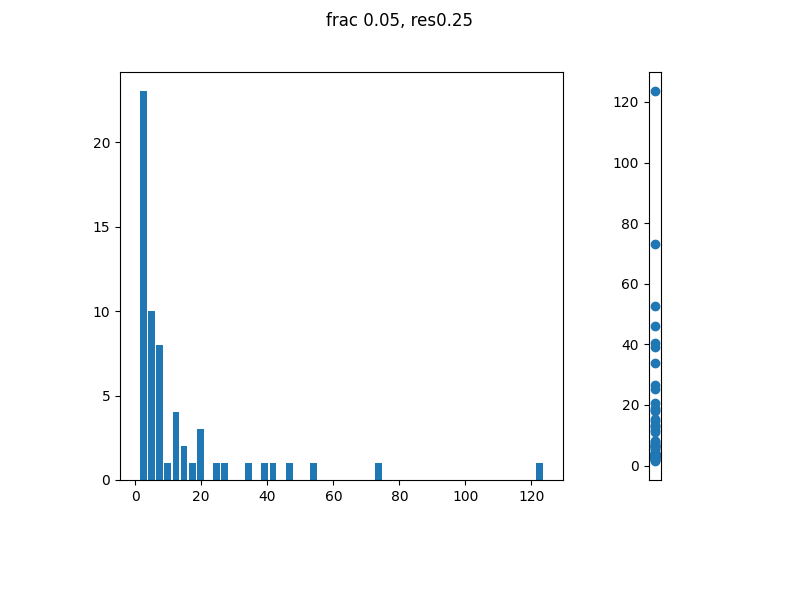

<IPython.core.display.Javascript object>


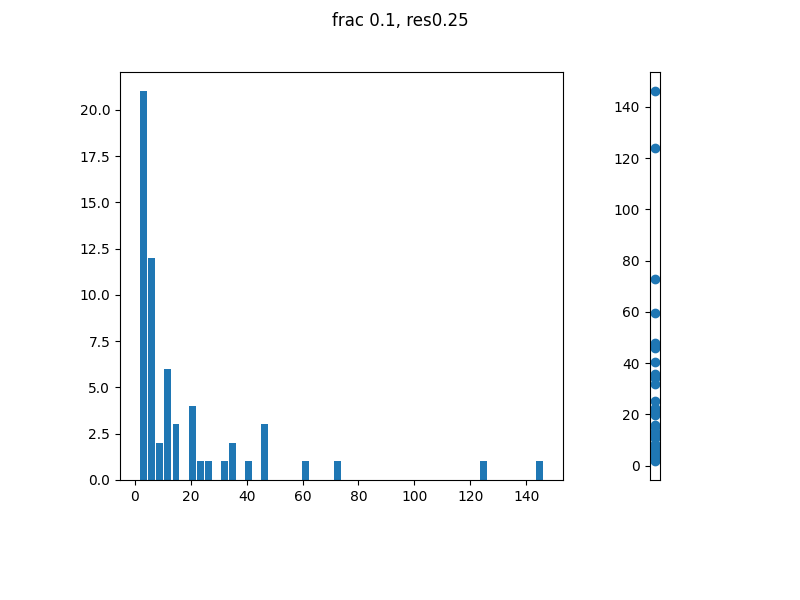

c:\users\natas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


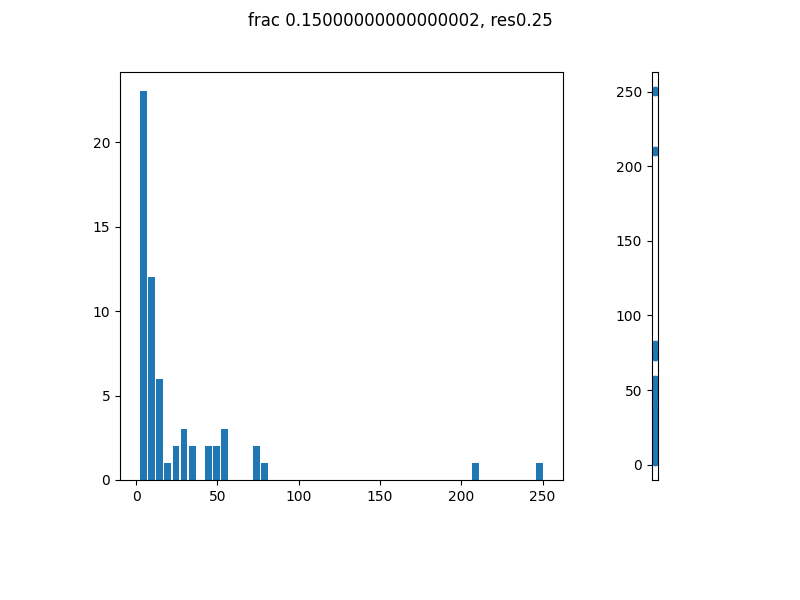

<IPython.core.display.Javascript object>


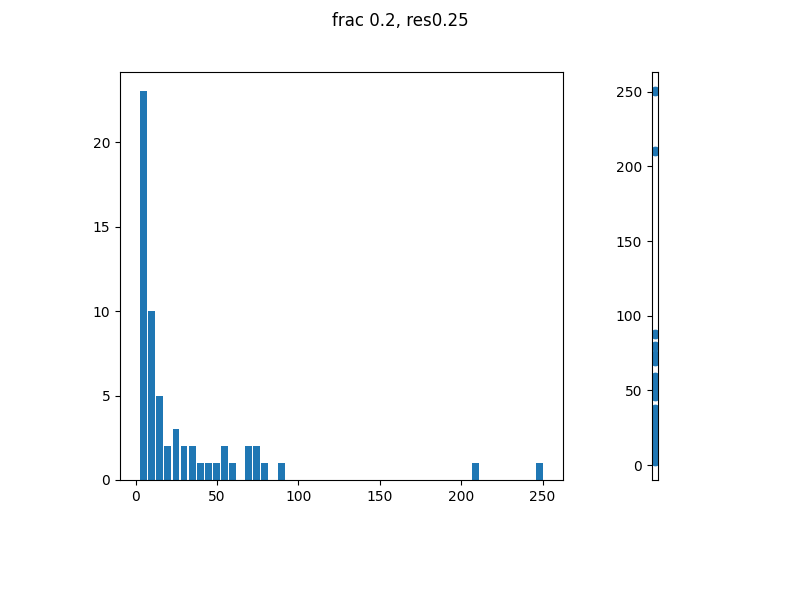

<IPython.core.display.Javascript object>


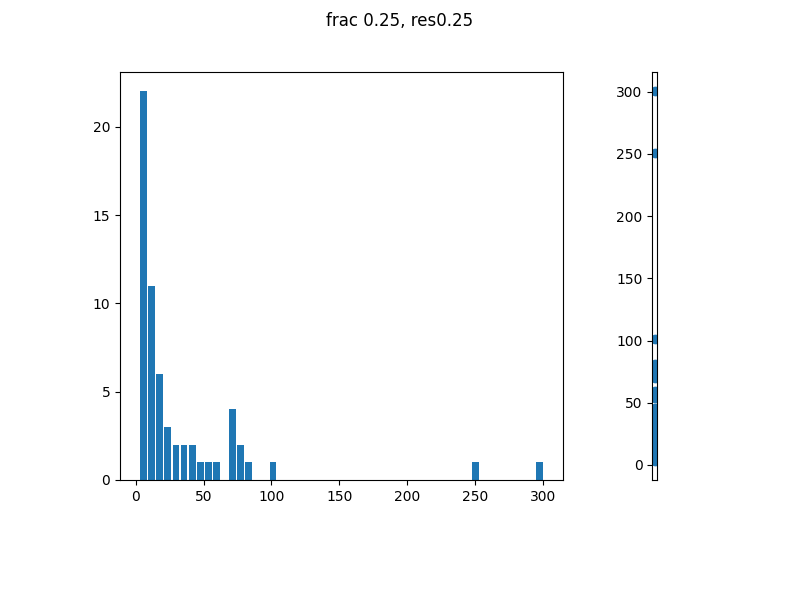

<IPython.core.display.Javascript object>


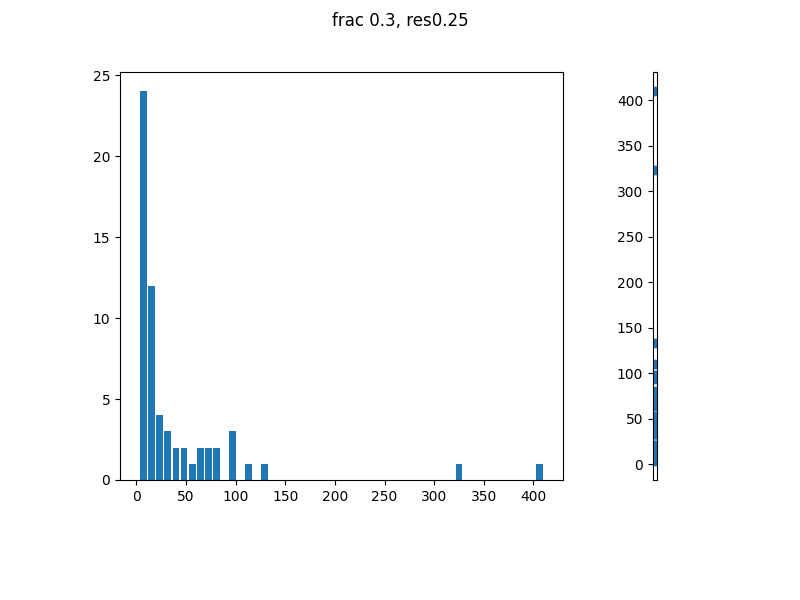

<IPython.core.display.Javascript object>


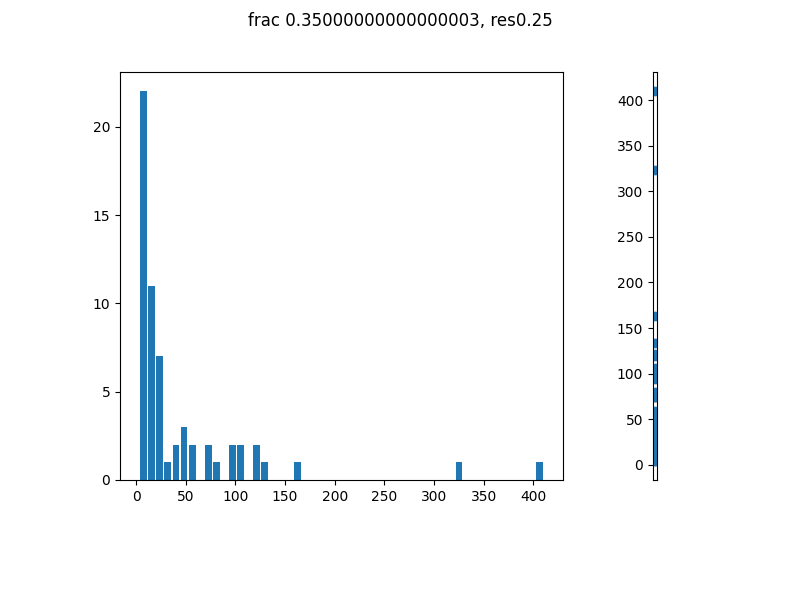

<IPython.core.display.Javascript object>


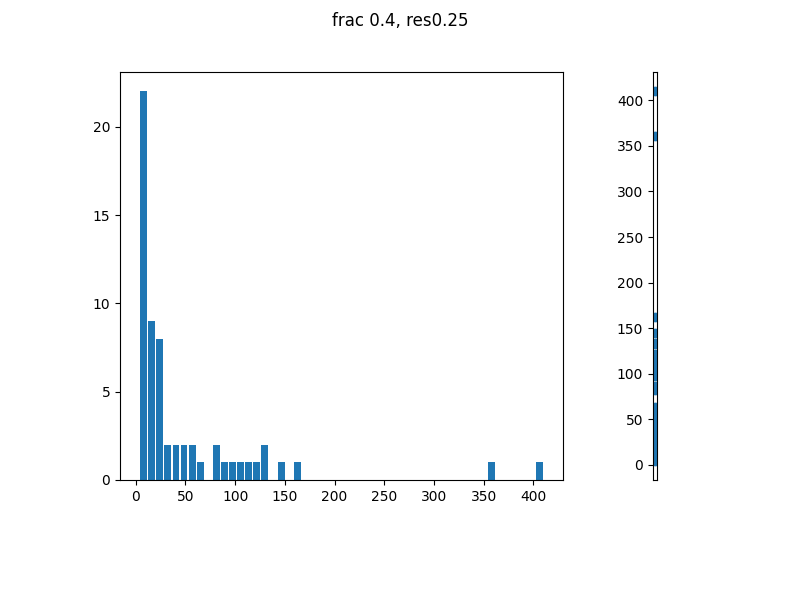

<IPython.core.display.Javascript object>


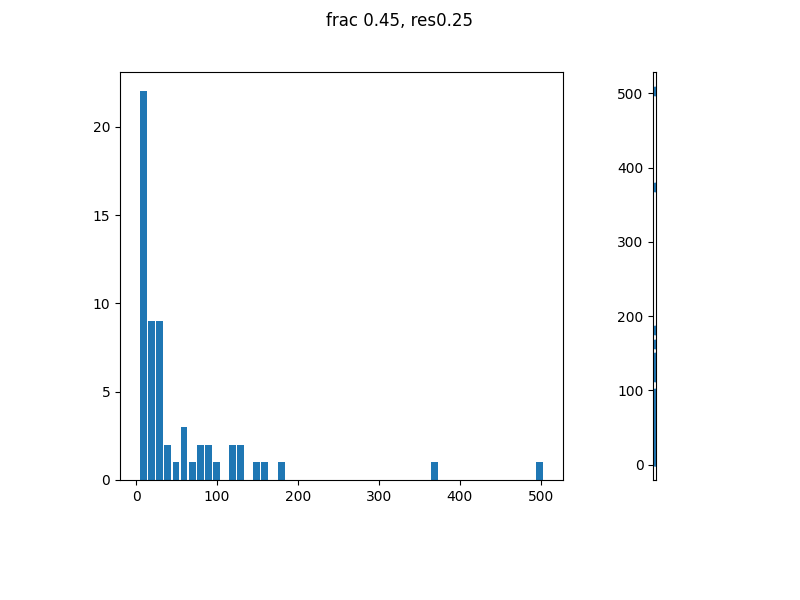

<IPython.core.display.Javascript object>


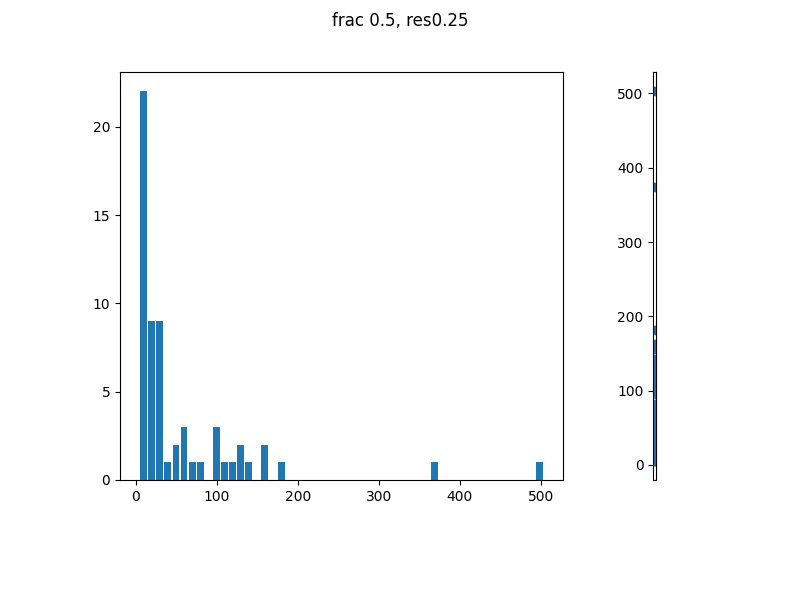

<IPython.core.display.Javascript object>


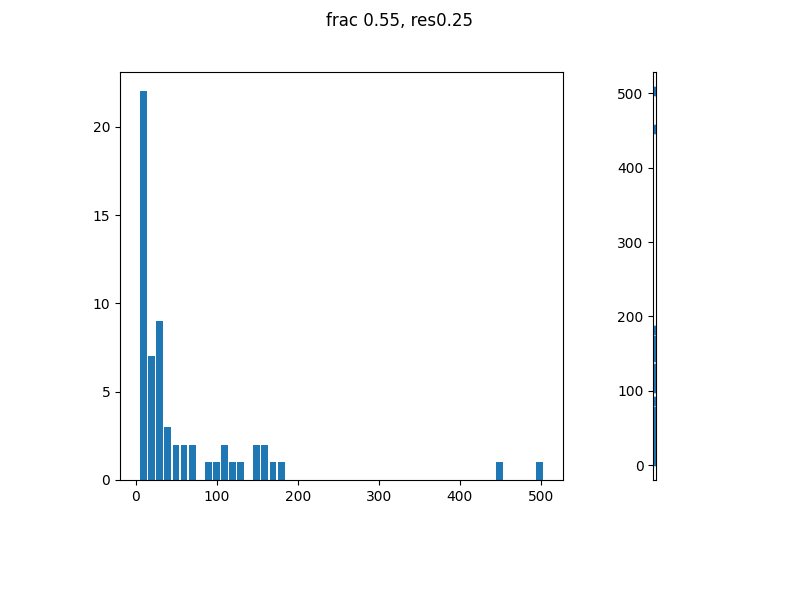

<IPython.core.display.Javascript object>


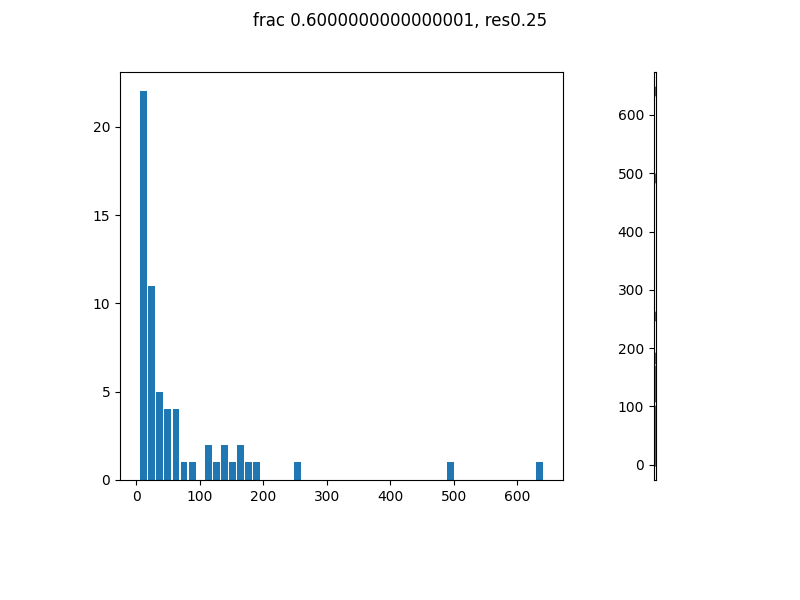

<IPython.core.display.Javascript object>


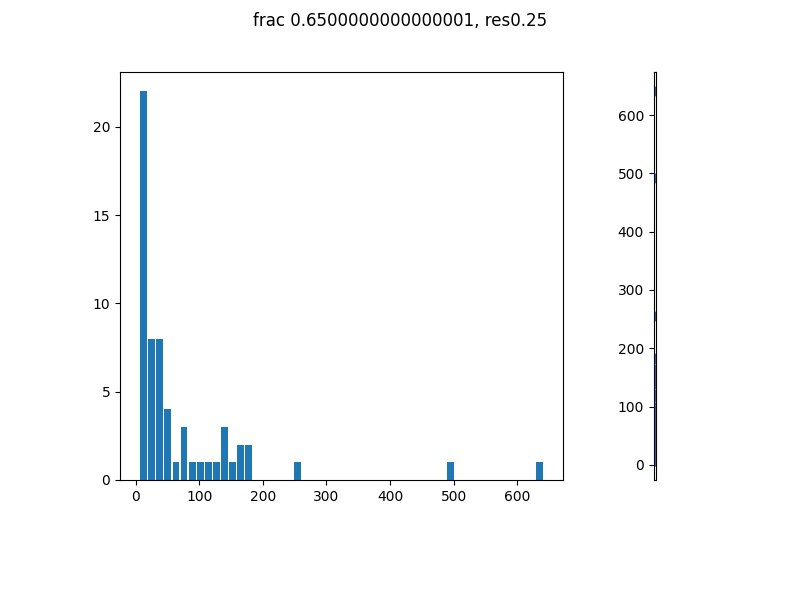

<IPython.core.display.Javascript object>


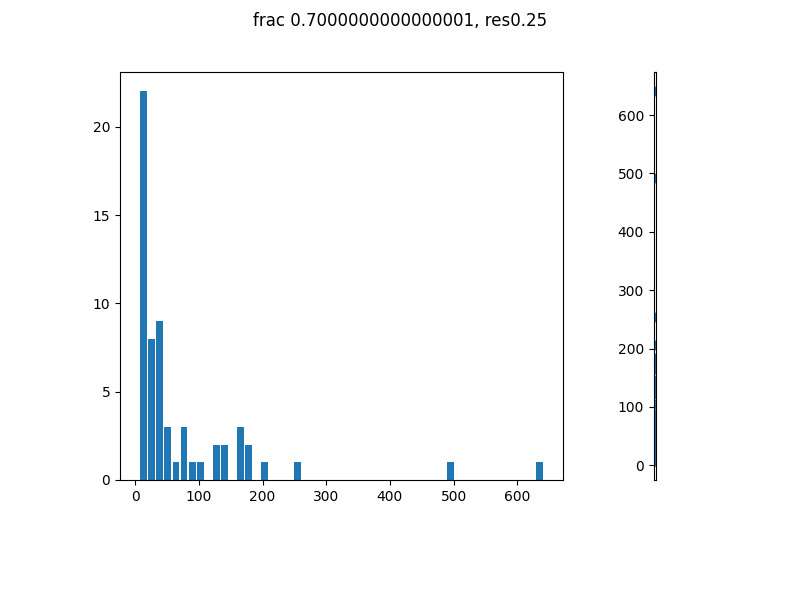

<IPython.core.display.Javascript object>


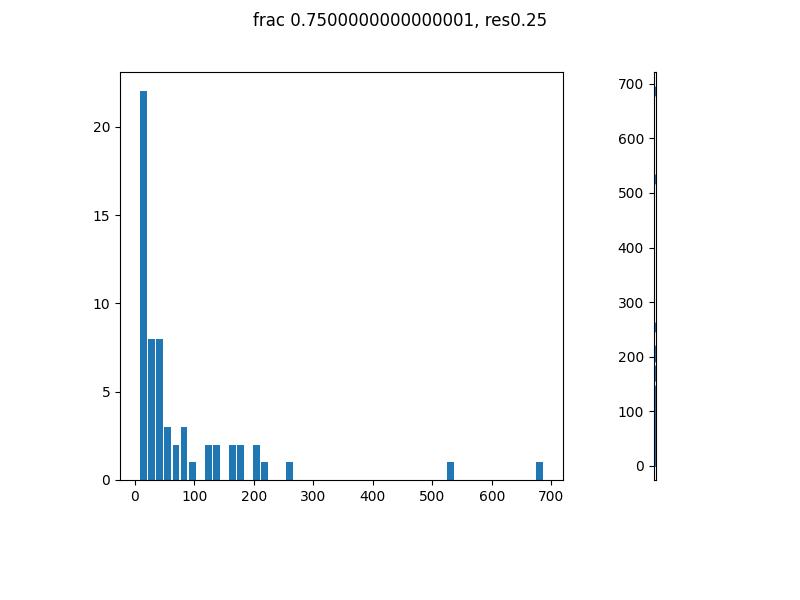

<IPython.core.display.Javascript object>


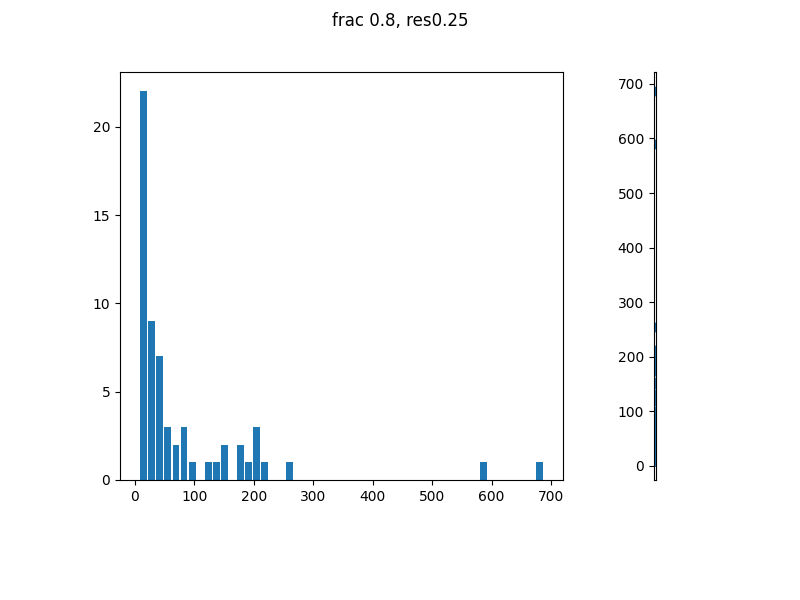

<IPython.core.display.Javascript object>


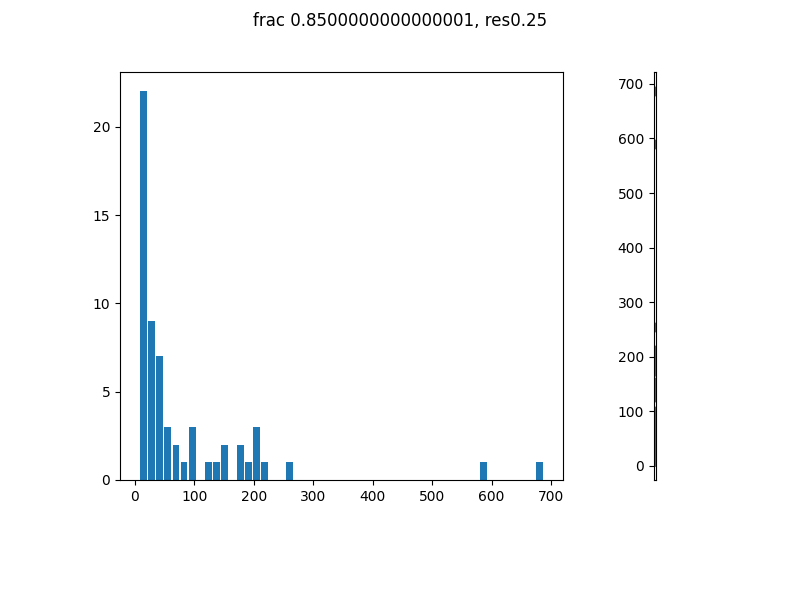

<IPython.core.display.Javascript object>


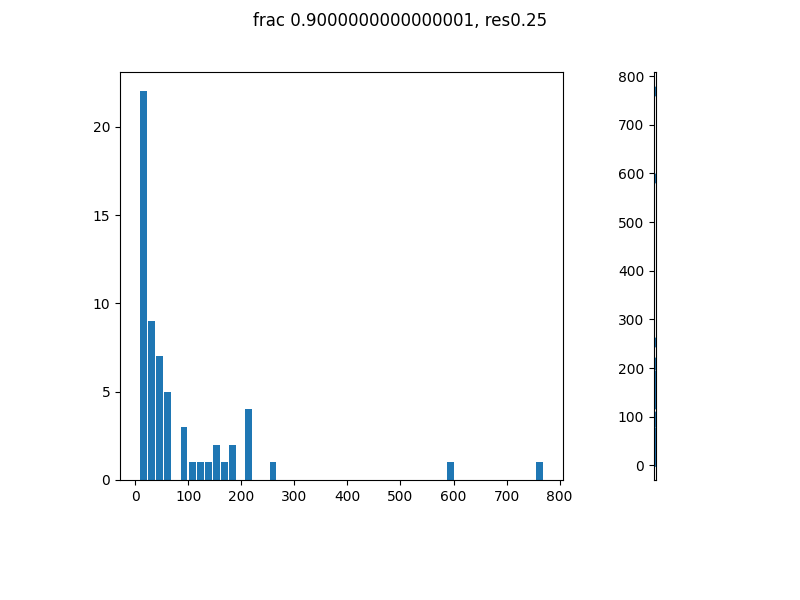

<IPython.core.display.Javascript object>


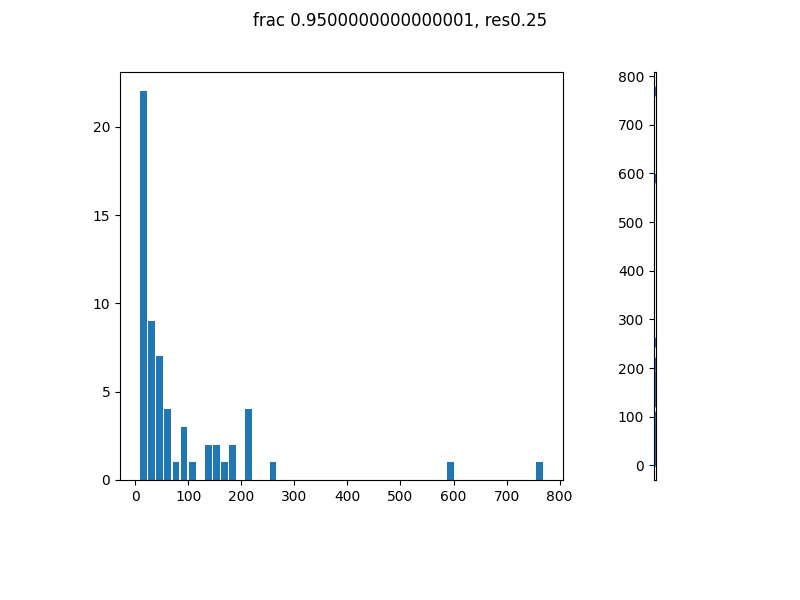

<IPython.core.display.Javascript object>


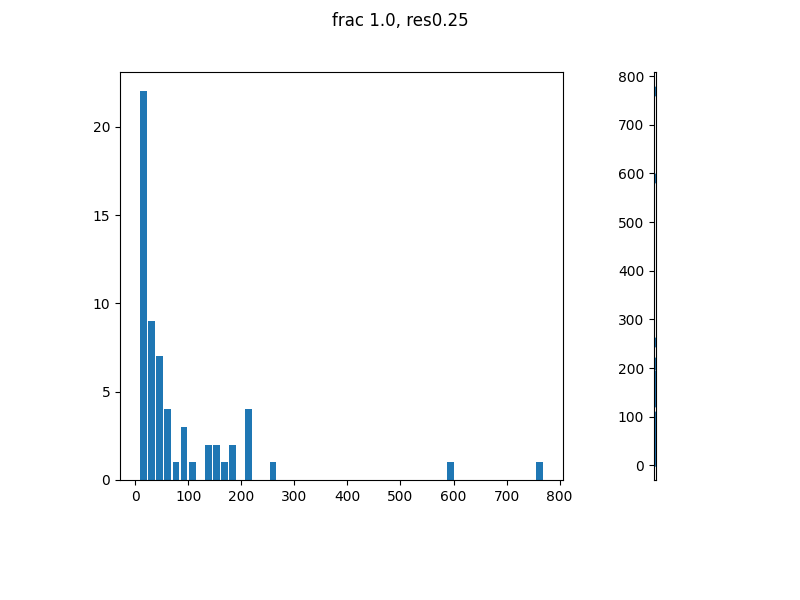

<IPython.core.display.Javascript object>


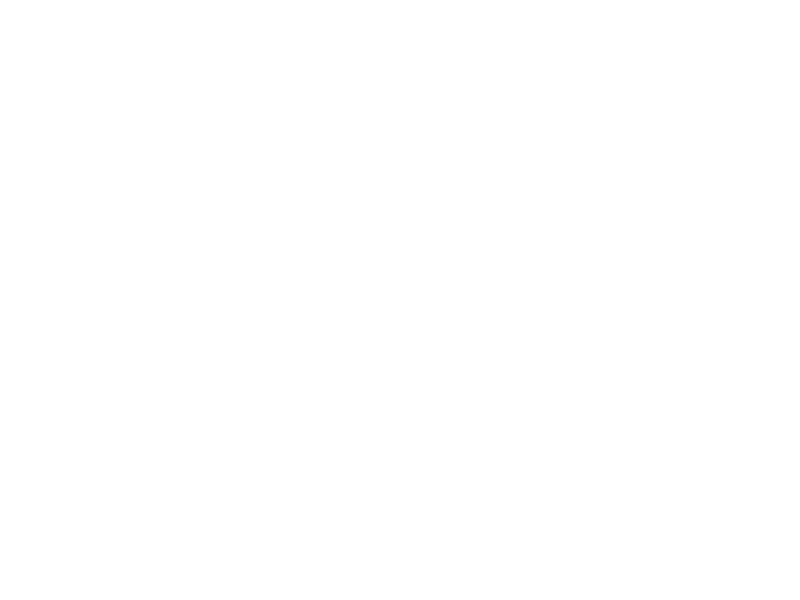

<IPython.core.display.Javascript object>


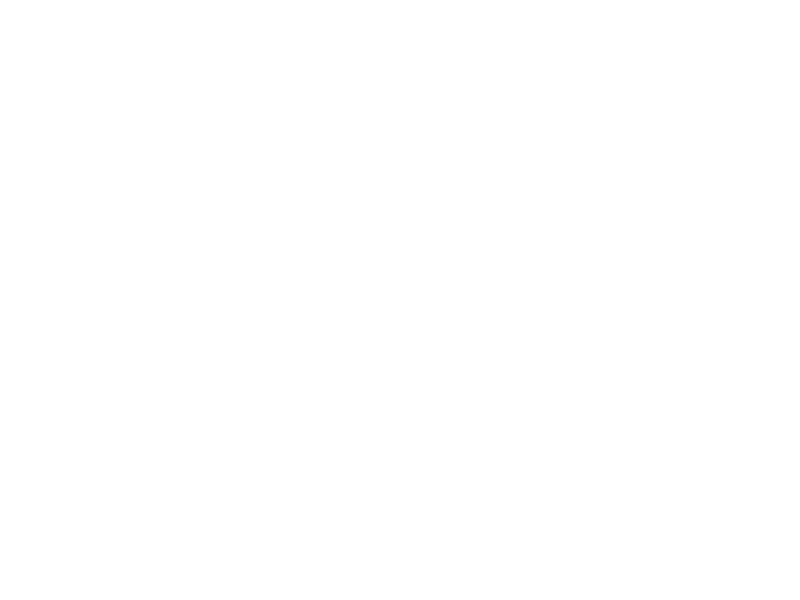

<IPython.core.display.Javascript object>


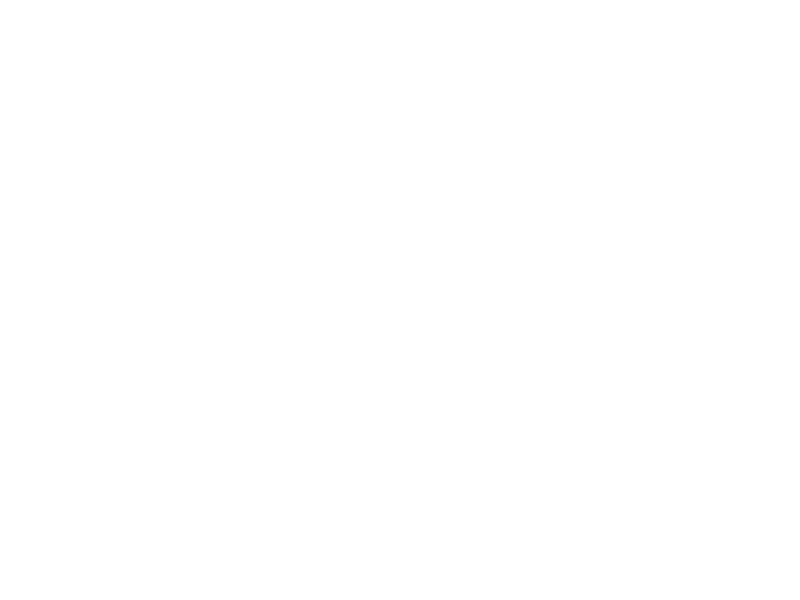

<IPython.core.display.Javascript object>


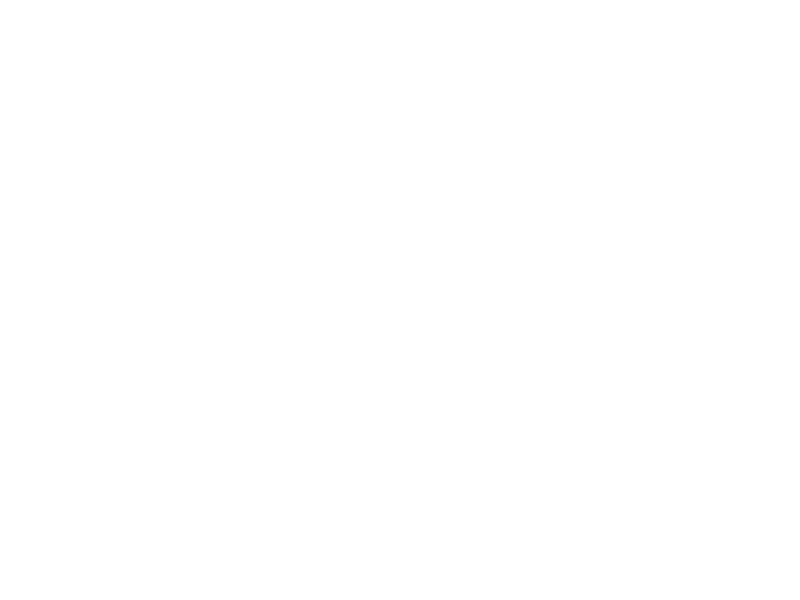

<IPython.core.display.Javascript object>


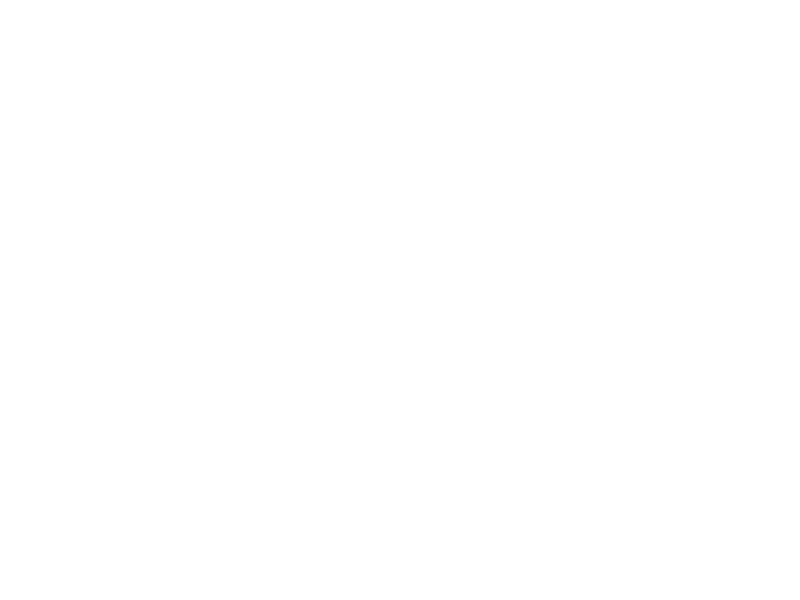

<IPython.core.display.Javascript object>


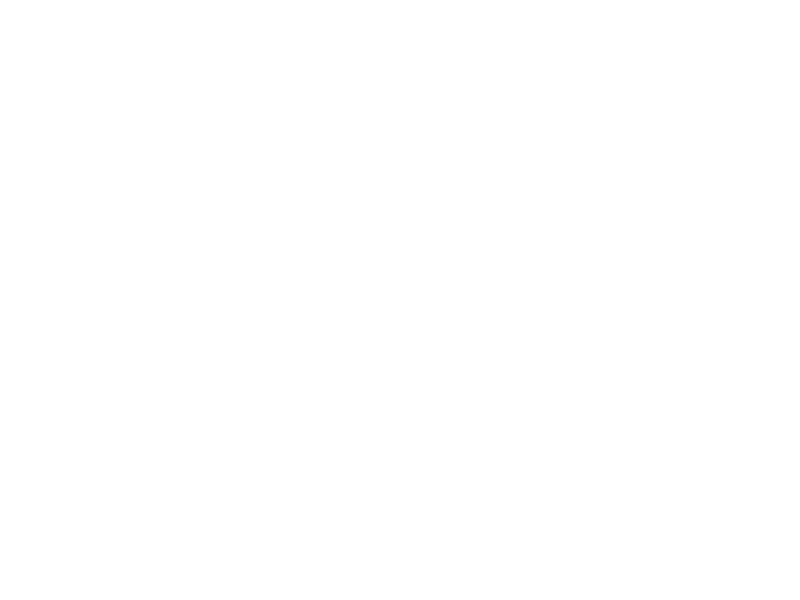

<IPython.core.display.Javascript object>


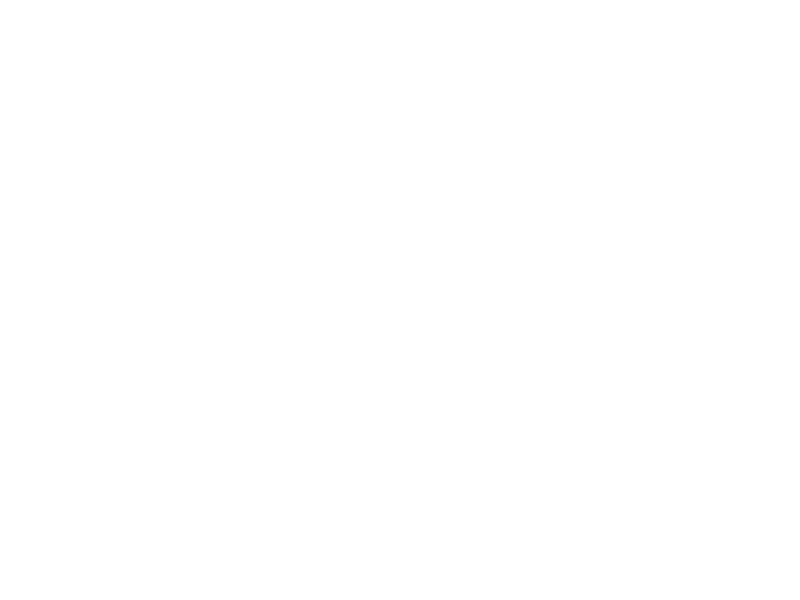

<IPython.core.display.Javascript object>


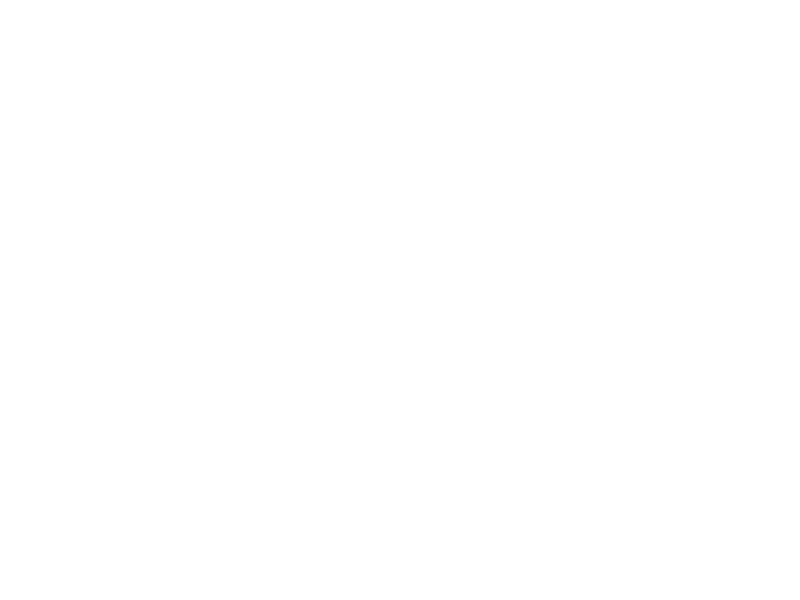

<IPython.core.display.Javascript object>


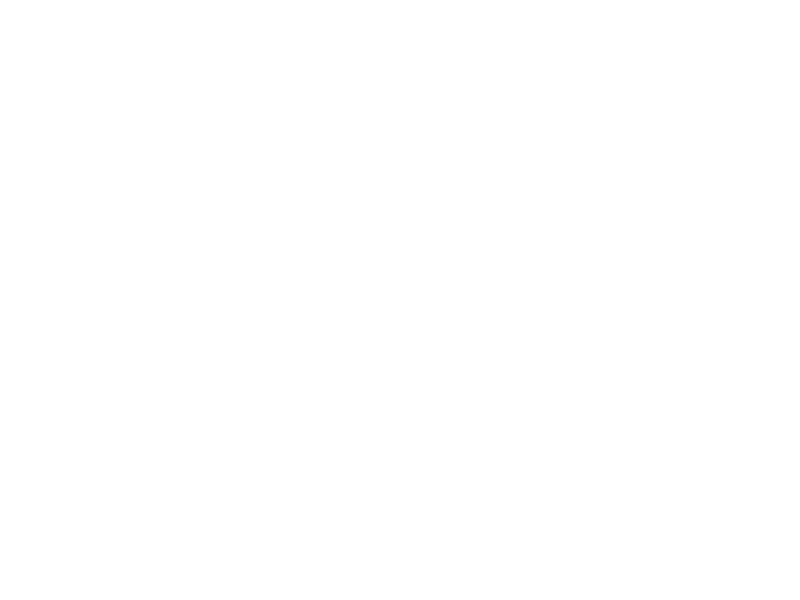

<IPython.core.display.Javascript object>


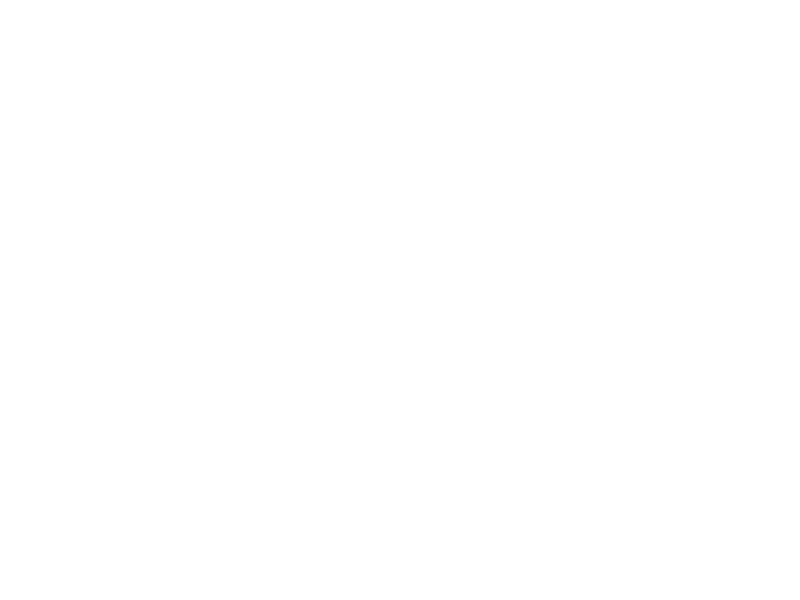

<IPython.core.display.Javascript object>


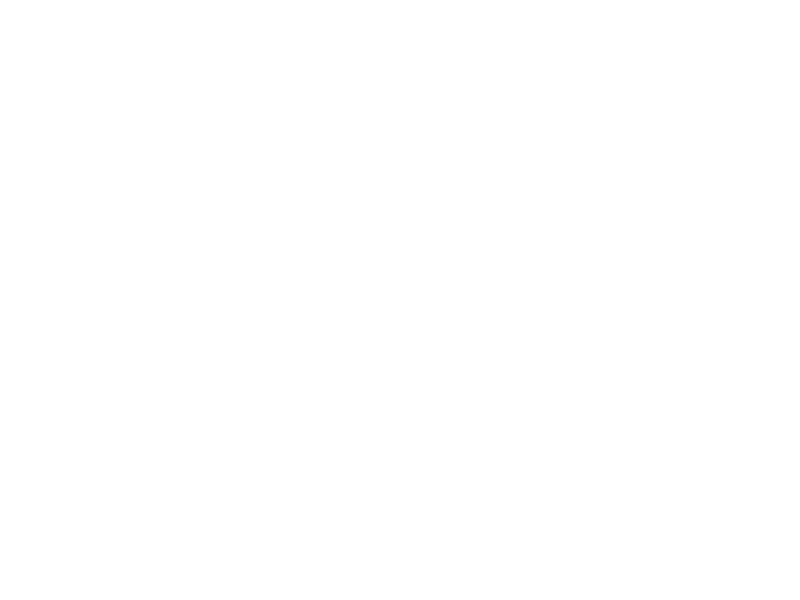

<IPython.core.display.Javascript object>


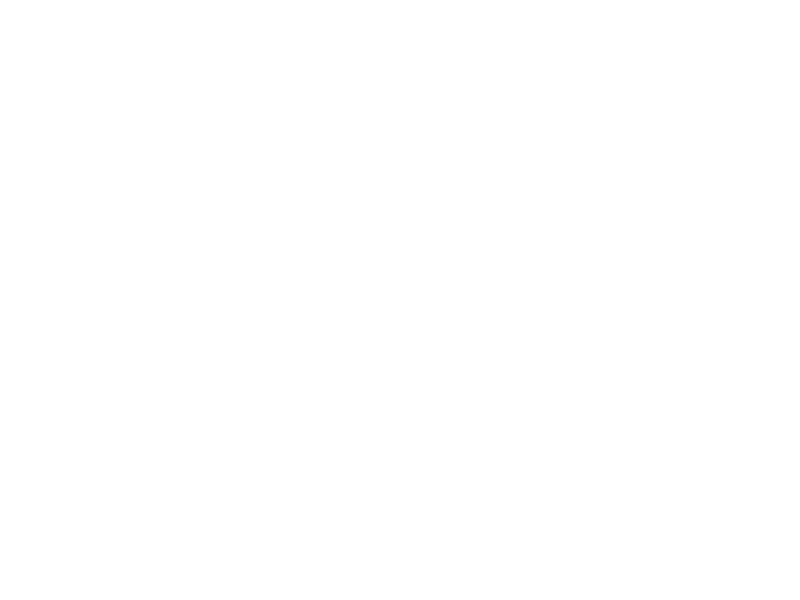

<IPython.core.display.Javascript object>


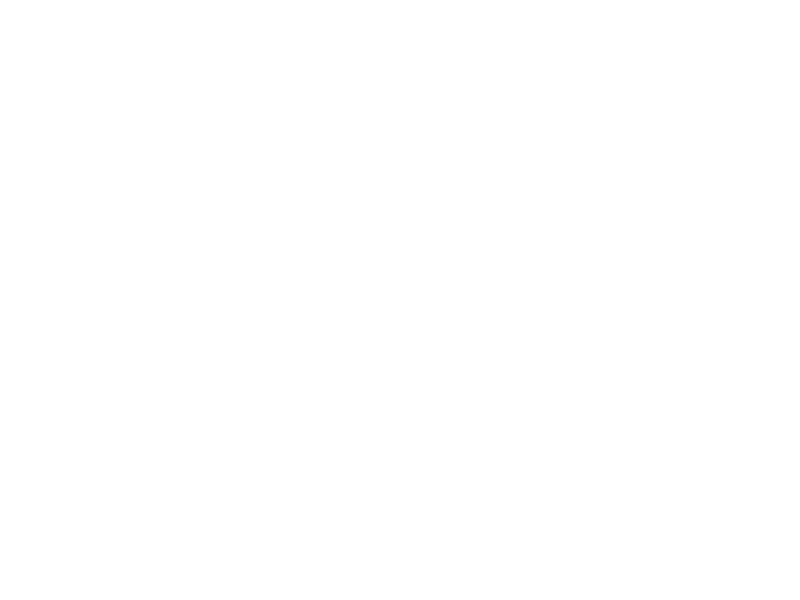

<IPython.core.display.Javascript object>


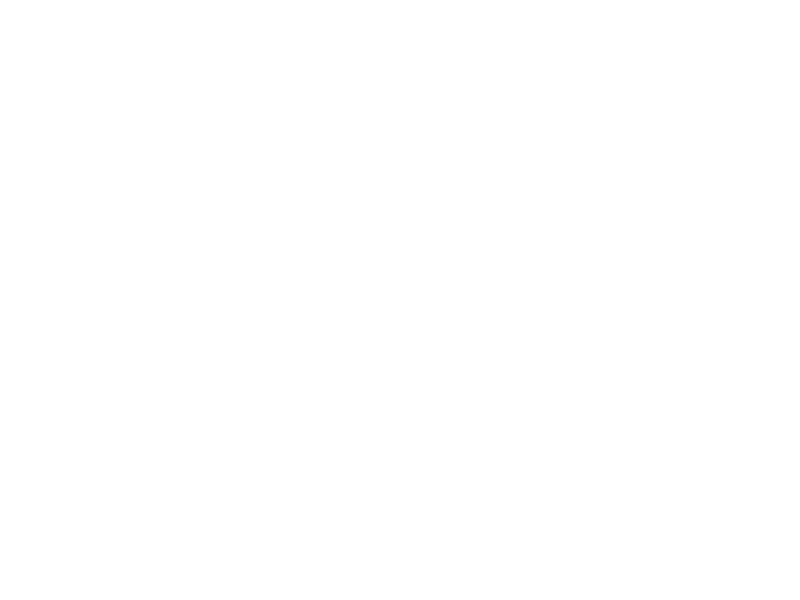

<IPython.core.display.Javascript object>


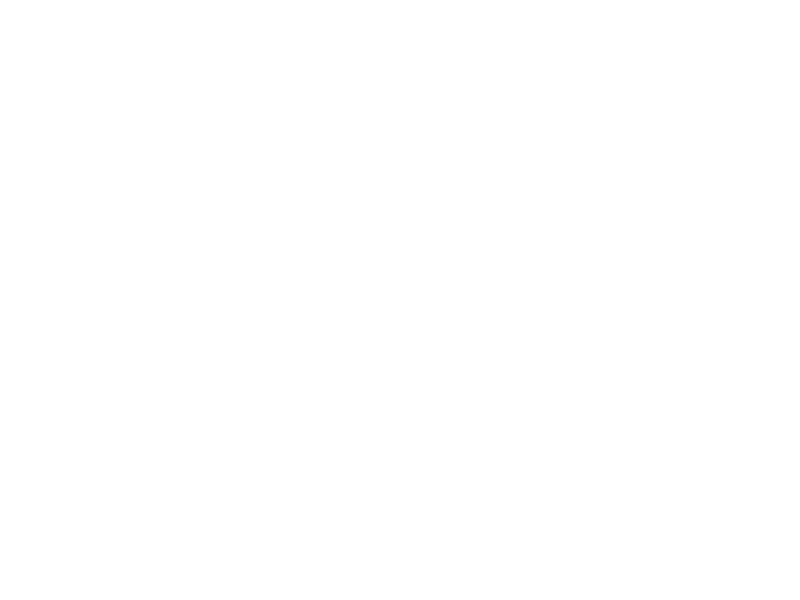

<IPython.core.display.Javascript object>


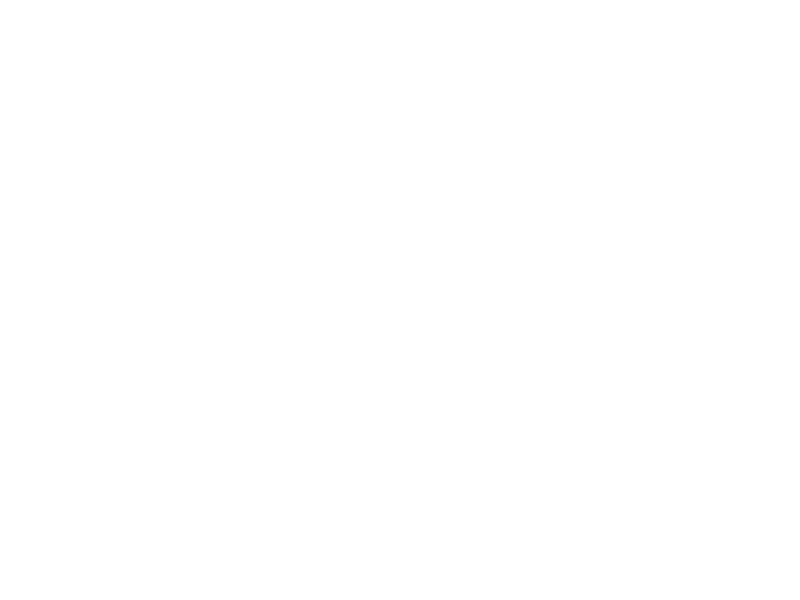

<IPython.core.display.Javascript object>


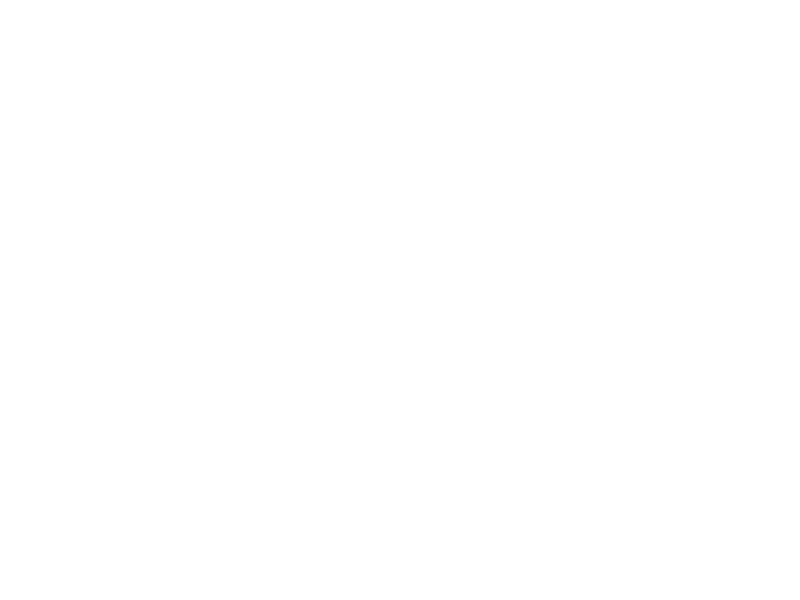

<IPython.core.display.Javascript object>


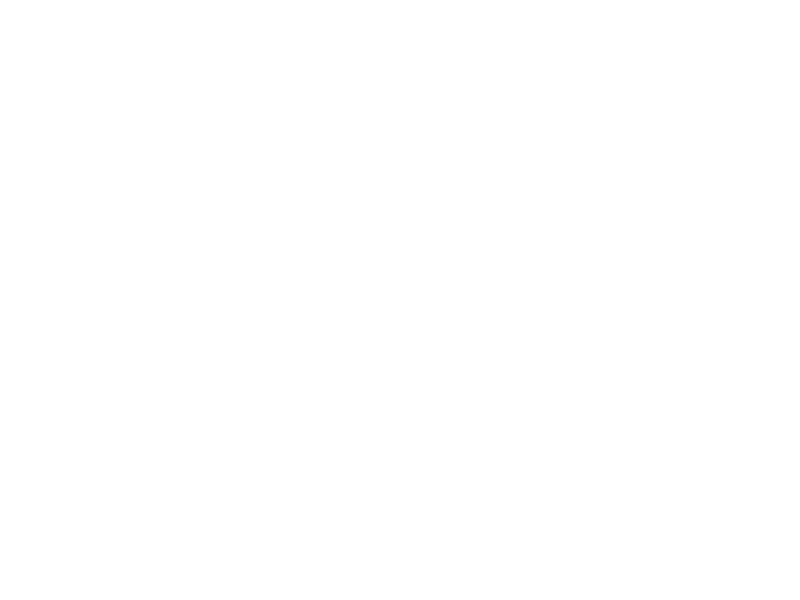

<IPython.core.display.Javascript object>


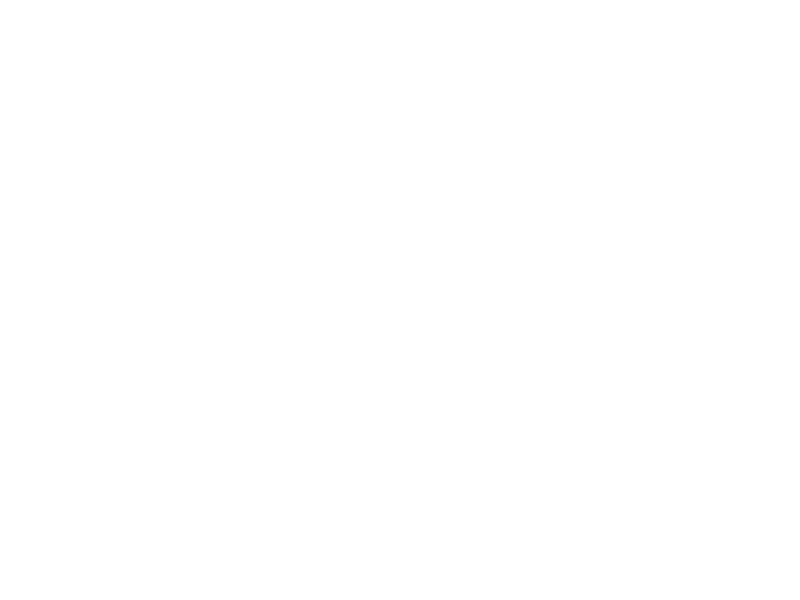

<IPython.core.display.Javascript object>


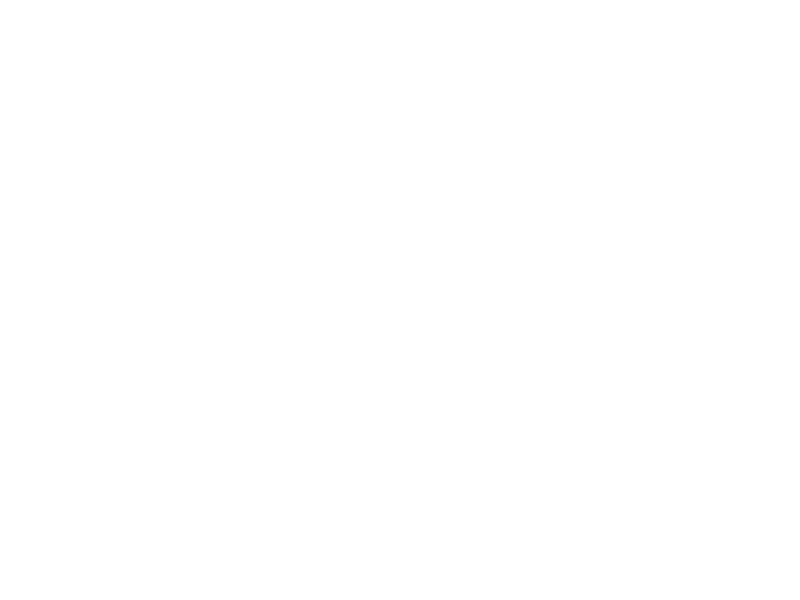

In [19]:
fracs = np.arange(0.05, 1.05, 0.05)
res = [0.25, 0.5]

for r in res:
    for frac in fracs:
        directionalities = calc_all_directionalities(frac, r)

        fig = plt.figure(figsize=(8,6))
        fig.suptitle(f"frac {frac}, res{r}")

        gs = fig.add_gridspec(1, 4)
        plt.subplots_adjust(left=0.15, bottom=0.2)

        ax1 = fig.add_subplot(gs[0, 0:3])
        ax1.hist(directionalities, bins=50, rwidth=0.85)

        ax2 = fig.add_subplot(gs[0, 3])

        x = [0] * len(directionalities)

        scatter2 = ax2.scatter(x, directionalities)
        ax2.set_xlim(-10, 10)
        ax2.axes.get_xaxis().set_visible(False)  # remove the x-axis and its ticks
        ax2.set_aspect(5, adjustable='box')  # adjustable='box' is important here

        plt.show()